# Testing of queue imbalance for company 9093

Order of this notebook is as follows:
1. [Data preparation](#Data-preparation)
2. [Data visualization](#Data-visualization)
3. [Tests](#Tests)
4. [Conclusions](#Conclusions)

Goal is to implement queue imbalance predictor from [1](#Resources).

In [1]:
import pandas as pd

from typing import Tuple
from datetime import datetime

import matplotlib.pyplot as plt
import matplotlib.dates as md
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import numpy as np
import lob

import warnings

warnings.filterwarnings('ignore')

## Data preparation

The data seems to be from small-tick market.

### Train data

For training data we used data from 2013-09 - 2013-10:

* 0901
* 0916
* 1001
* 1016

### Test data

For testing data we used data from first half of 2013-11

* 1101

In [2]:
df, df_test = lob.load_data('9063')
df.head()

Training set length: 13272
Testing set length: 3257


,bid,ask,bid_price,ask_price,mid_price,sum_sell_ask,sum_buy_bid,mid_price_indicator,queue_imbalance
2013-09-02 09:00:00,"[(320.0, 50200.0), (343.0, 20000.0), (345.0, 2...","[(445.3, 1178.0), (445.35, 8406.0), (445.4, 41...",445.10,445.3,445.200,1178.0,300.0,1.0,-0.594046
2013-09-02 09:01:00,"[(320.0, 50200.0), (343.0, 20000.0), (345.0, 2...","[(445.6, 2375.0), (445.65, 3104.0), (445.7, 76...",445.50,445.6,445.550,2375.0,599.0,1.0,-0.597176
2013-09-02 09:02:00,"[(320.0, 50200.0), (343.0, 20000.0), (345.0, 2...","[(445.7, 5653.0), (445.75, 4595.0), (445.8, 82...",445.55,445.7,445.625,5653.0,2779.0,0.0,-0.340844
2013-09-02 09:03:00,"[(320.0, 50200.0), (343.0, 20000.0), (345.0, 2...","[(445.6, 7880.0), (445.65, 11785.0), (445.7, 2...",445.40,445.6,445.500,7880.0,8349.0,0.0,0.028899
2013-09-02 09:04:00,"[(320.0, 50200.0), (343.0, 20000.0), (345.0, 2...","[(445.5, 13423.0), (445.55, 13615.0), (445.6, ...",445.30,445.5,445.400,13423.0,16940.0,0.0,0.115832


In [ ]:
def tick_size(df):
    bid_total = ''
    for number, price in df['bid']:

## Data visualization

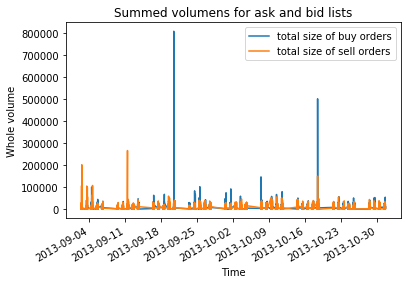

In [3]:
df['sum_buy_bid'].plot(label='total size of buy orders')
df['sum_sell_ask'].plot(label='total size of sell orders')
plt.title('Summed volumens for ask and bid lists')
plt.xlabel('Time')
plt.ylabel('Whole volume')
plt.legend()

Text(0,0.5,'Price')

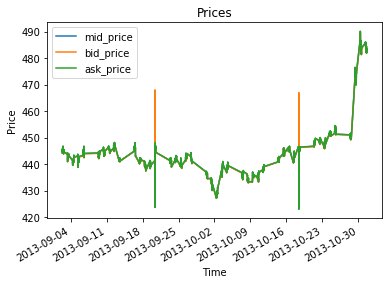

In [4]:
df[['mid_price', 'bid_price', 'ask_price']].plot()
plt.legend()
plt.title('Prices')
plt.xlabel('Time')
plt.ylabel('Price')

Text(0.5,1,'Queue imbalance vs mid price indicator for a few records')

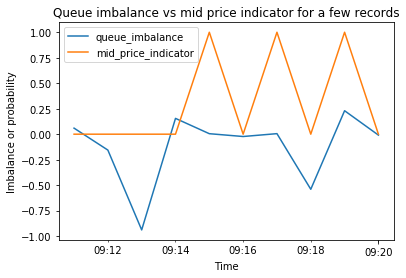

In [5]:
df.iloc[10:20][['queue_imbalance', 'mid_price_indicator']].plot()
plt.legend()
plt.xlabel('Time')
plt.ylabel('Imbalance or probability')
plt.title('Queue imbalance vs mid price indicator for a few records')

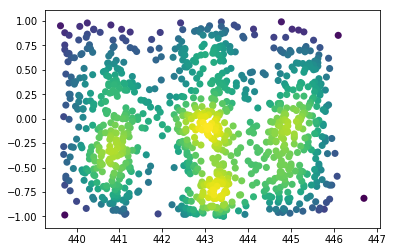

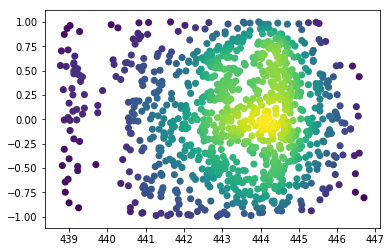

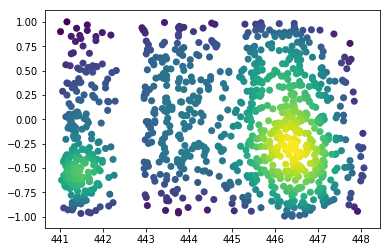

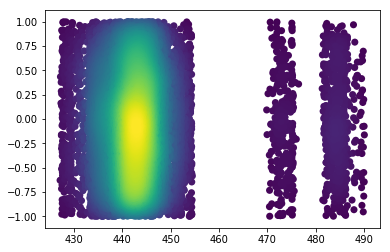

In [48]:
def plot_density_imbalance_vs_mid(df, st, end):    
    y = df['queue_imbalance'].iloc[st:end].values
    x = df['mid_price'].iloc[st:end].values
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    # that most dense points are plotted last
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]

    fig, ax = plt.subplots()
    ax.scatter(x, y, c=z, s=50, edgecolor='')
    plt.figure()
p(df, 0, 1000)
p(df, 1000, 2000)
p(df, 2000, 3000)
p(df, 0, len(df))
#plt.scatter(df['mid_price'].iloc[0:100], df['queue_imbalance'].iloc[0:100])

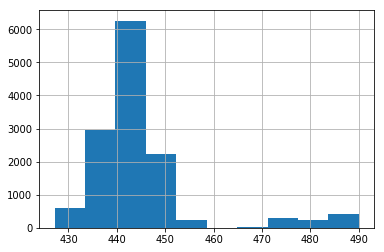

In [38]:
df['mid_price'].hist()

[2.6385043  2.68908265 2.6385043  ... 2.6385043  2.6385043  2.68908265]


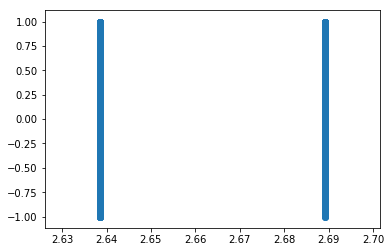

In [36]:
from scipy.stats import gaussian_kde

z = gaussian_kde(df['mid_price_indicator'])
print(z(df['mid_price_indicator']))
plt.scatter(z(df['mid_price_indicator']), df['queue_imbalance'])

(array([1107., 1309., 1470., 1575., 1620., 1587., 1417., 1259., 1048.,
         880.]),
 array([-9.99874119e-01, -7.99891702e-01, -5.99909285e-01, -3.99926868e-01,
        -1.99944451e-01,  3.79655591e-05,  2.00020382e-01,  4.00002799e-01,
         5.99985216e-01,  7.99967633e-01,  9.99950050e-01]),
 <a list of 10 Patch objects>)

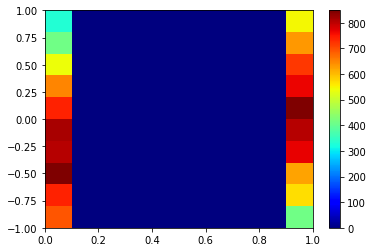

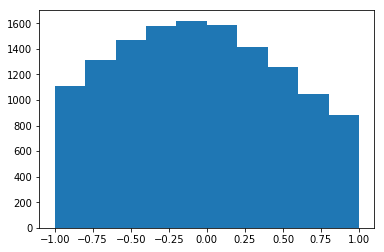

In [30]:
plt.hist2d(df['mid_price_indicator'].values,df['queue_imbalance'].values, cmap=plt.cm.jet)
plt.colorbar()
plt.figure()
plt.hist(df['queue_imbalance'].values)

Text(0.5,1,'Mid price indicator density')

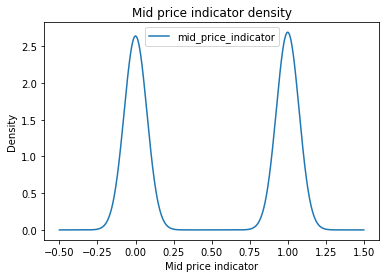

In [6]:
df['mid_price_indicator'].plot('kde')
plt.legend()
plt.xlabel('Mid price indicator')
plt.title('Mid price indicator density')

Text(0.5,1,'Queue imbalance density')

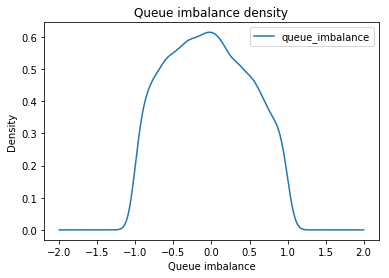

In [7]:
df['queue_imbalance'].plot('kde')
plt.legend()
plt.xlabel('Queue imbalance')
plt.title('Queue imbalance density')

## Tests

We use logistic regression to predict `mid_price_indicator`.

[0.004494457527102786, 0.24733024396526243, 0.25, 0.45747620509671477]


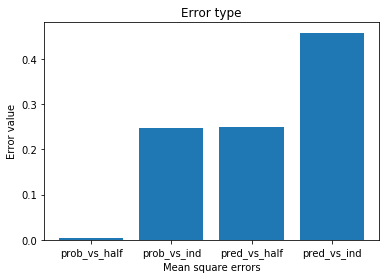

In [8]:
reg = lob.logistic_regression(df, 0, len(df))

probabilities = reg.predict_proba(df_test['queue_imbalance'].values.reshape(-1,1))
probabilities = [p1 for p0, p1 in probabilities]
prob_vs_half = ((0.5 * np.ones(len(probabilities)) - probabilities) ** 2).mean()
prob_vs_ind = ((df_test['mid_price_indicator'] - probabilities) ** 2).mean()

predictions = reg.predict(df_test['queue_imbalance'].values.reshape(-1, 1))
pred_vs_half = ((0.5 * np.ones(len(predictions)) - predictions) ** 2).mean()
pred_vs_ind = ((df_test['mid_price_indicator'] - predictions) ** 2).mean()

plt.bar(np.arange(4), [prob_vs_half, prob_vs_ind, pred_vs_half, pred_vs_ind])
plt.xticks(np.arange(4), ['prob_vs_half', 'prob_vs_ind', 'pred_vs_half', 'pred_vs_ind'])
plt.xlabel('Mean square errors')
plt.ylabel('Error value')
plt.title('Error type')
print([prob_vs_half, prob_vs_ind, pred_vs_half, pred_vs_ind])

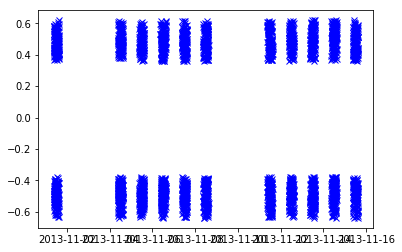

In [72]:
plt.plot(((df_test['mid_price_indicator'] - probabilities)), 'bx')

Text(0,0.5,'Prediction')

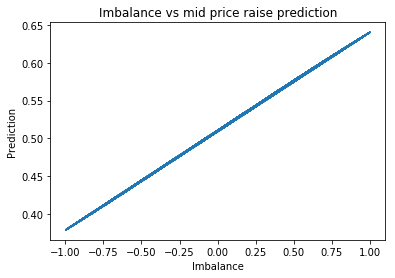

In [9]:
plt.plot(df_test['queue_imbalance'].values, 
         lob.sigmoid(reg.coef_[0] * df_test['queue_imbalance'].values + reg.intercept_))
plt.title('Imbalance vs mid price raise prediction')
plt.xlabel('Imbalance')
plt.ylabel('Prediction')

Text(0,0.5,'Mid price prediction')

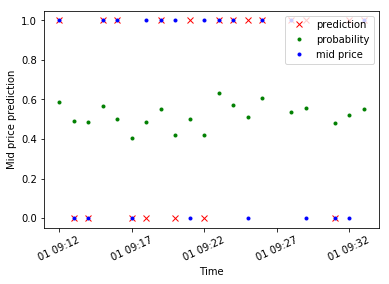

In [65]:
st = 10
end = 30

plt.plot(df_test.index[st:end], predictions[st:end], 'rx', label='prediction')
plt.plot(df_test.index[st:end], probabilities[st:end], 'g.', label='probability')
plt.plot(df_test.index[st:end], df_test['mid_price_indicator'].values[st:end], 'b.', label='mid price')
plt.xticks(rotation=25)
plt.legend(loc=1)
plt.xlabel('Time')
plt.ylabel('Mid price prediction')

## Conclusions

Looking at mid_price_indicator density plot it seems that bid and ask queues are balanced. The same conclusion we can get from queue imbalance density plot - it looks like normal distribution: most often the queues are balanced.

Errors:
* predicted probability vs null model: 0.0000
* predicted probability vs known indicator: 0.2498
* prediction vs null model: 0.25
* prediction vs known indicator: 0.4873

Probabilistic classification works about 25% better than null model. Its values are between 0.48-0.52, which is the reason of why mean square error between probabilistic predictions and null model is almost 0.

Binary classification works less than 2% better than null model.

### Resources

1. [Queue Imbalance as a One-Tick-Ahead Price Predictor in a Limit Order Book](https://arxiv.org/abs/1512.03492) <a class="anchor-link" href="#1">¶</a> 